In [1]:
#import the neccesary libraries
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from PIL import Image
import numpy as np
import skimage
import skimage.transform
import os
import tensorflow.keras.backend as K
from skimage.metrics import structural_similarity as ssim
import math
from tensorflow.keras.applications.vgg16 import VGG16
from sobel_edge import sobel 

os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
import skimage.transform

def CreateSet(input_list,input_dir,output_dir,N_patches,patchsize,H,W):
    """
    Creates an array that can be used as input and output for the model
    parameters: input_list, a list with indices of the images that are used
                N_patches, the amount of image patches the model creates per image
                patchsize, the width and height of the square image patch
    
    """
    X = np.zeros((len(input_list)*N_patches, patchsize, patchsize, 1), dtype=np.float32)
    y = np.zeros((len(input_list)*N_patches, patchsize, patchsize, 1), dtype=np.float32)
    for j in range(N_patches):
        for n,i in enumerate(input_list):
            #random pixel location
            ii = j*len(input_list)+n
            xloc = random.randint(0,W-patchsize)
            yloc = random.randint(0,H-patchsize)
            #input 
            img_input1 = Image.open('bandLimited/input_%03d.png' % (i+1))
            in_img_input1 = tf.keras.preprocessing.image.img_to_array(img_input1)
            in_img_input1 = in_img_input1[yloc:yloc+patchsize,xloc:xloc+patchsize]
            in_img_input1 = skimage.transform.resize(in_img_input1 , (patchsize , patchsize , 1) , mode = 'constant' , preserve_range = True)

            #Input from model 2
            img_input2 = Image.open('bandlimited_SRCNNmodel2/input_%03d.png' % (i+1))
            in_img_input2 = tf.keras.preprocessing.image.img_to_array(img_input2)
            in_img_input2 = in_img_input2[yloc:yloc+patchsize,xloc:xloc+patchsize]
            in_img_input2 = skimage.transform.resize(in_img_input2 , (patchsize , patchsize , 1) , mode = 'constant' , preserve_range = True)
            X1 = in_img_input1 / 255.0
            X2 = in_img_input2 / 255.0
            X[ii] = X1
            #output
            img_output = Image.open('groundTruth/target_%03d.png' % (i+1))
            in_img_output = tf.keras.preprocessing.image.img_to_array(img_output)
            in_img_output = in_img_output[yloc:yloc+patchsize,xloc:xloc+patchsize]
            in_img_output = skimage.transform.resize(in_img_output , (patchsize , patchsize , 1) , mode = 'constant' , preserve_range = True)

            y[ii] = (in_img_output / 255.0) - X2
            if ii % 1000 == 0:
                    print(ii)
    print('Done')
    return X,y
#This function can be used for small datasets 
#amount of patches per image
N_patches = 64
#width and height of the patches
patchsize = 128
#image dimensions
H=801
W=401
input_dir = 'bandLimited'
output_dir = 'groundTruth'
# input_dir = 'CIRSBandLimited'
# output_dir = 'CIRSGroundTruth'
# input_dir = 'carotidBandLimited'
# output_dir = 'carotidGroundTruth'

#Train set is image 1 till 401
X_train,y_train = CreateSet(range(401),input_dir,output_dir,N_patches,patchsize,H,W)
#validation set is image 402 till 535
X_valid,y_valid = CreateSet(range(401,535),input_dir,output_dir,N_patches,patchsize,H,W)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
Done
0
1000
2000
3000
4000
5000
6000
7000
8000
Done


In [4]:
def SRCNN():
    # lrelu = LeakyReLU(alpha=0.1)
    SRCNN = tf.keras.Sequential()
    SRCNN.add(tf.keras.layers.Conv2D(filters=128, kernel_size= (9,9),  kernel_initializer='glorot_uniform',
                     activation='relu', padding='same', input_shape=(None, None, 1)))
    SRCNN.add(tf.keras.layers.Conv2D(filters=64, kernel_size= (3,3),  kernel_initializer='glorot_uniform',
                     activation='relu', padding='same'))
    # SRCNN.add(BatchNormalization())
    SRCNN.add(tf.keras.layers.Conv2D(filters=1, kernel_size= (5,5),  kernel_initializer='glorot_uniform',
                     activation='linear', padding='same'))
    adam = tf.keras.optimizers.Adam(lr=0.0003)
    SRCNN.compile(optimizer=adam, loss=CustomMSE, metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return SRCNN


In [5]:
def CustomMSE(y_predict,y_true):
    factor = 1e3
    mse = factor*K.mean(K.square(y_predict-y_true))
    return mse
    

In [6]:
#define and compile the model
model = SRCNN()

In [7]:
model_path = 'model_SRCNN_Cascade_ultrasound.h5'
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.0001, verbose=1),
    tf.keras.callbacks.ModelCheckpoint(model_path, verbose=1, save_best_only=True, save_weights_only=True)
]

In [8]:
#load the model
# model.load_weights(model_path)

In [23]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, None, None, 128)   10496     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, None, None, 64)    73792     
_________________________________________________________________
conv2d_11 (Conv2D)           (None, None, None, 1)     1601      
Total params: 85,889
Trainable params: 85,889
Non-trainable params: 0
_________________________________________________________________


In [8]:
#train the model
results = model.fit(X_train,y_train, epochs=100, callbacks=callbacks,batch_size = 16,
                    validation_data=(X_valid,y_valid),shuffle=False)


Epoch 1/100
1602/1604 [============================>.] - ETA: 0s - loss: 8.7701 - root_mean_squared_error: 0.0936
Epoch 00001: val_loss improved from inf to 8.87511, saving model to model_SRCNN_Cascade_ultrasound.h5
1604/1604 [==============================] - 36s 23ms/step - loss: 8.7705 - root_mean_squared_error: 0.0937 - val_loss: 8.8751 - val_root_mean_squared_error: 0.0942 - lr: 3.0000e-04
Epoch 2/100
1602/1604 [============================>.] - ETA: 0s - loss: 8.7346 - root_mean_squared_error: 0.0935
Epoch 00002: val_loss did not improve from 8.87511
1604/1604 [==============================] - 36s 23ms/step - loss: 8.7351 - root_mean_squared_error: 0.0935 - val_loss: 8.8751 - val_root_mean_squared_error: 0.0942 - lr: 3.0000e-04
Epoch 3/100
1604/1604 [==============================] - ETA: 0s - loss: 8.7243 - root_mean_squared_error: 0.0934
Epoch 00003: val_loss did not improve from 8.87511
1604/1604 [==============================] - 35s 22ms/step - loss: 8.7243 - root_mean_squa

dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error', 'lr'])


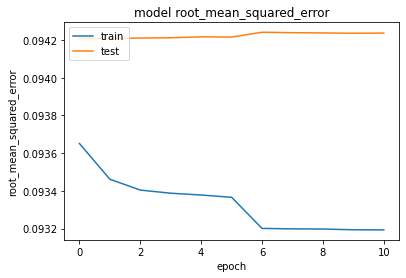

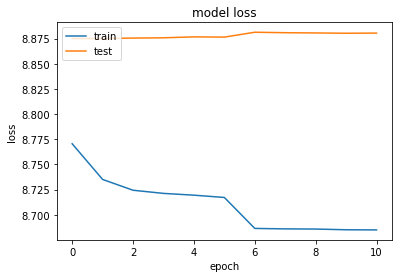

In [9]:
#visualise the accuracy and losses of the model
# list all data in history
print(results.history.keys())
# summarize history for accuracy
plt.plot(results.history['root_mean_squared_error'])
plt.plot(results.history['val_root_mean_squared_error'])
plt.title('model root_mean_squared_error')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [10]:
#Create the arrays for the Test set which are the image 535 till 669
def CreateTestSet(test_set_indices,input_dir_test,output_dir_test):
    """
    Function that reads in the test sets images as arrays and scales them between 0 and 1
    parameters:test_set_indices: The indices of the the images in the test set
                 input_dir_test: The directory where the input png images are stored
                output_dir_test: The directory where the output png images are stored
    returns: Test_set_X: an array of input images
             Test_set_y: an array of output images
    """
    Test_set_X = np.zeros((len(test_set_indices), 801, 401, 1), dtype=np.float32)
    Test_set_y = np.zeros((len(test_set_indices), 801, 401, 1), dtype=np.float32)
    for i,n in enumerate(test_set_indices):
        img = Image.open(input_dir_test+'/input_%03d.png' % (n+1))
        in_img_input = tf.keras.preprocessing.image.img_to_array(img)
        in_img_input = skimage.transform.resize(in_img_input , (801 , 401 , 1) , mode = 'constant' , preserve_range = True)
        Test_set_X[i] =in_img_input / 255.0

        img = Image.open(output_dir_test+'/target_%03d.png' % (n+1))
        in_img_output = tf.keras.preprocessing.image.img_to_array(img)
        in_img_output = skimage.transform.resize(in_img_output , (801 , 401 , 1) , mode = 'constant' , preserve_range = True)
        Test_set_y[i] =in_img_output / 255.0    
    print('Done')
    return Test_set_X, Test_set_y
#Run for all datasets
for dataset in ['','CIRS_','carotid_']:
    if dataset == '':
        test_set_indices = range(535,669)
        input_dir_test = 'bandLimited'
        output_dir_test = 'groundTruth'
    if dataset == 'CIRS_':
        test_set_indices = range(11)
        input_dir_test = 'CIRSBandLimited'
        output_dir_test = 'CIRSGroundTruth'
    if dataset =='carotid_':
        test_set_indices = range(70)
        input_dir_test = 'carotidBandLimited'
        output_dir_test = 'carotidGroundTruth'
    #Define the test sets
    Test_set_X, Test_set_y = CreateTestSet(test_set_indices,input_dir_test,output_dir_test)
    #Load the saved npy file for the M2 model
    modeloutput = np.load('Model_output_test_'+dataset+'SRCNNmodel2_ultrasound.npy')
    #Create an array with prediction images
    prediction_images = np.zeros_like(Test_set_X.squeeze())
    for i in range(len(Test_set_X)):
        predicted_array = model.predict(np.expand_dims(Test_set_X[i] , 0))
        prediction_IMAGE = modeloutput[i]+predicted_array.squeeze()
        prediction_images[i] = prediction_IMAGE
    #save the array as an npy file
    np.save('Model_output_test_'+dataset+'SRCNNmodel3_ultrasound.npy',prediction_images)

Done
Done
Done


In [ ]:
n =2

prediction = model.predict(np.expand_dims(Test_set_X[n], 0))
modeloutput = np.load('Model_output_test_SRCNNmodel2_ultrasound.npy')

prediction_image = prediction.squeeze()

fig,ax = plt.subplots(1,3, figsize=(12,6))
ax[0].imshow(Test_set_X[n].squeeze(),cmap = 'gray')
ax[1].imshow(prediction_image+modeloutput[n],cmap='gray')
ax[2].imshow(Test_set_y[n].squeeze(),cmap='gray')
plt.show()

In [16]:
modeloutput = np.load('Model_output_test_SRCNNmodel2_ultrasound.npy')
prediction_images = np.zeros_like(Test_set_X.squeeze())
for i in range(len(Test_set_X)):
    predicted_array = model.predict(np.expand_dims(Test_set_X[i] , 0))
    prediction_IMAGE = modeloutput[i]+predicted_array.squeeze()
    prediction_images[i] = prediction_IMAGE
np.save('Model_output_test_SRCNNmodel3_ultrasound.npy',prediction_images)